In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
import wandb

import csng
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import plot_losses, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, crop
from csng.losses import SSIMLoss, MSELossWithCrop, Loss
from csng.readins import MultiReadIn, FCReadIn, ConvReadIn
from csng.GAN import GAN

from data import (
    prepare_v1_dataloaders,
    SyntheticDataset,
    BatchPatchesDataLoader,
    MixedBatchLoader,
    PerSampleStoredDataset,
)
from gan_utils import (
    train,
    val,
    get_dataloaders,
)

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "cat_V1_spiking_model", "50K_single_trial_dataset")
print(f"{DATA_PATH=}")

/home/jsobotka/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


DATA_PATH='/media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset'


In [2]:
config = {
    "data": {
        "mixing_strategy": "parallel_min", # needed only with multiple base dataloaders
    },
    "crop_win": (20, 20),
    "only_cat_v1_eval": True,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    # "wandb": None,
    "wandb": {
        "project": "CSNG",
        "group": "cat_v1_50k",
    },
}

print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [4]:
dataloaders = dict()

### V1 dataset (spiking model of cat V1)

In [5]:
config["data"]["cat_v1"] = {
    "train_path": os.path.join(DATA_PATH, "datasets", "train"),
    "val_path": os.path.join(DATA_PATH, "datasets", "val"),
    "test_path": os.path.join(DATA_PATH, "datasets", "test"),
    "image_size": [50, 50],
    "crop": False,
    "batch_size": 64,
    "stim_keys": ("stim",),
    "resp_keys": ("exc_resp", "inh_resp"),
    "return_coords": True,
    "return_ori": False,
    "coords_ori_filepath": os.path.join(DATA_PATH, "pos_and_ori.pkl"),
    "cached": False,
    "stim_normalize_mean": 46.143,
    "stim_normalize_std": 20.420,
    "resp_normalize_mean": torch.load(
        os.path.join(DATA_PATH, "responses_mean.pt")
    ),
    "resp_normalize_std": torch.load(
        os.path.join(DATA_PATH, "responses_std.pt")
    ),
}

In [6]:
### get data loaders
dataloaders["cat_v1"] = prepare_v1_dataloaders(**config["data"]["cat_v1"])

Train dataset size: 45000. Validation dataset size: 5000. Test dataset size: 250.


stim.shape=torch.Size([64, 1, 50, 50]), resp.shape=torch.Size([64, 46875])
stim.min()=tensor[] -2.260, stim.max()=tensor[] 2.637
resp.min()=tensor[] -2.957, resp.max()=tensor[] 17.289
stim.mean()=tensor[] 0.058, stim.std()=tensor[] 1.252
resp.mean()=tensor[] 0.003, resp.std()=tensor[] 1.061
neuron_coords.shape=torch.Size([64, 46875, 2]), neuron_coords.dtype=torch.float32
neuron_coords.min()=tensor[] -2.500, neuron_coords.max()=tensor[] 2.500


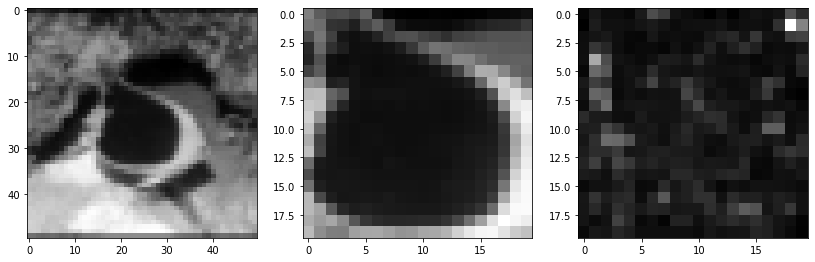

In [7]:
### show data
sample_data_key = "cat_v1"
datapoint = next(iter(dataloaders["cat_v1"]["test"]))
stim, resp, neuron_coords = datapoint.images, datapoint.responses, datapoint.neuron_coords.float()
print(
    f"{stim.shape=}, {resp.shape=}"
    f"\n{stim.min()=}, {stim.max()=}"
    f"\n{resp.min()=}, {resp.max()=}"
    f"\n{stim.mean()=}, {stim.std()=}"
    f"\n{resp.mean()=}, {resp.std()=}"
    f"\n{neuron_coords.shape=}, {neuron_coords.dtype=}"
    f"\n{neuron_coords.min()=}, {neuron_coords.max()=}"
    # f"\n{ori.min()=}, {ori.max()=}"
)

### plot sample data
sample_idx = 0
fig = plt.figure(figsize=(14, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx], config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

# ax = fig.add_subplot(133)
# ax.imshow(resp[0].view(125, 375).squeeze(0).unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 20, 20 # number of bins in each dimension
min_x, max_x, min_y, max_y = neuron_coords[sample_idx,:,0].min().item(), neuron_coords[sample_idx,:,0].max().item(), neuron_coords[sample_idx,:,1].min().item(), neuron_coords[sample_idx,:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_x_bins):
    for j in range(n_y_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[i] <= neuron_coords[sample_idx,:,0]) &\
               (neuron_coords[sample_idx,:,0] < x_bins[i + 1]) &\
               (y_bins[j] <= neuron_coords[sample_idx,:,1]) &\
               (neuron_coords[sample_idx,:,1] < y_bins[j + 1])
        binned_resp[j,i] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")
plt.show()

plt.show()

### Synthetic data (different stimuli dataset -> encoder -> neuronal responses)

In [ ]:
resp_mean = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data", "responses_mean.npy"))).float()
resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data", "responses_std.npy"))).float()

config["data"]["syn_data"] = {
    "dataset": {
        "stim_transform": transforms.Normalize(
            mean=114.457,
            std=51.356,
        ),
        "resp_transform": csng.utils.Normalize(
            mean=resp_mean,
            std=resp_std,
        ),
    },
    "dataloader": {
        "batch_size": 20,
        "shuffle": True,
    }
}

In [ ]:
syn_datasets = {
    "train": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "train"),
        **config["data"]["syn_data"]["dataset"]
    ),
    "val": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "val"),
        **config["data"]["syn_data"]["dataset"]
    ),
    "test": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data", "processed", "test"),
        **config["data"]["syn_data"]["dataset"]
    ),
}

dataloaders["syn_data"] = {
    "train": DataLoader(
        dataset=syn_datasets["train"],
        **config["data"]["syn_data"]["dataloader"],
    ),
    "val": DataLoader(
        dataset=syn_datasets["val"],
        **config["data"]["syn_data"]["dataloader"],
    ),
    "test": DataLoader(
        dataset=syn_datasets["test"],
        **config["data"]["syn_data"]["dataloader"],
    ),
}

In [ ]:
### calculate statistics

### for stimuli
# syn_stats = get_mean_and_std(dataset=syn_dataset, verbose=True)
# syn_stats

### for responses
# from csng.utils import RunningStats

# stats = RunningStats(num_components=10000, lib="torch", device="cuda")
# for i, (s, r) in enumerate(syn_dataloader):
#     stats.update(r)
#     if i % 200 == 0:
#         print(f"{i}: {r.mean()=} {r.std()=} {stats.get_mean()=} {stats.get_std()=}")

### save
# torch.save(stats.get_mean(), os.path.join(DATA_PATH, "responses_mean_from_syn_dataset.pt"))
# torch.save(stats.get_std(), os.path.join(DATA_PATH, "responses_std_from_syn_dataset.pt"))


### generate preprocessed synthetic data
# import pickle
# target_dir = os.path.join(DATA_PATH, "synthetic_data", "processed")

# for data_split in ("train", "val", "test"):
#     print(data_split)
#     ### get the whole batch from dataloaders and save to disk
#     sample_idx = 0
#     for stim, resp in syn_dataloaders[data_split]:
#         if sample_idx % 2000 == 0:
#             print("  ", sample_idx)
        
#         for i in range(stim.shape[0]):
#             sample_idx += 1
#             save_to = os.path.join(target_dir, data_split, f"{sample_idx}.pickle")

#             data = {"stim": stim[i].cpu(), "resp": resp[i].cpu()}
#             with open(save_to, "wb") as f:
#                 pickle.dump(data, f)

In [ ]:
### show data
syn_stim, syn_resp = next(iter(dataloaders["syn_data"]["val"]))
print(
    f"{syn_stim.shape=}, {syn_resp.shape=}"
    f"\n{syn_stim.min()=}, {syn_stim.max()=}"
    f"\n{syn_resp.min()=}, {syn_resp.max()=}"
    f"\n{syn_stim.mean()=}, {syn_stim.std()=}"
    f"\n{syn_resp.mean()=}, {syn_resp.std()=}"
)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim.cpu()[0].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(syn_stim.cpu()[0], config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
ax.imshow(syn_resp.cpu()[0].view(100, 100).squeeze(0).unsqueeze(-1), cmap="gray")

plt.show()

### Synthetic data (V1 data stimuli -> encoder -> neuronal responses)

In [ ]:
### load
resp_mean = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "responses_mean_original.npy"))).float()
resp_std = torch.from_numpy(np.load(os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "responses_std_original.npy"))).float()

config["data"]["syn_data_v1_enc"] = {
    "dataset": {
        "stim_transform": transforms.Normalize(
            mean=0,
            std=1,
        ),
        "resp_transform": csng.utils.Normalize(
            mean=resp_mean,
            std=resp_std,
        ),
    },
    "dataloader": {
        "batch_size": 30,
        "shuffle": True,
    }
}

In [ ]:
syn_datasets_v1_encoder = {
    "train": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "train"),
        **config["data"]["syn_data_v1_enc"]["dataset"]
    ),
    "val": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "val"),
        **config["data"]["syn_data_v1_enc"]["dataset"]
    ),
    "test": PerSampleStoredDataset(
        dataset_dir=os.path.join(DATA_PATH, "synthetic_data_v1_encoder", "test"),
        **config["data"]["syn_data_v1_enc"]["dataset"]
    ),
}

dataloaders["syn_data_v1_enc"] = {
    "train": DataLoader(
        dataset=syn_datasets_v1_encoder["train"],
        **config["data"]["syn_data_v1_enc"]["dataloader"],
    ),
    "val": DataLoader(
        dataset=syn_datasets_v1_encoder["val"],
        **config["data"]["syn_data_v1_enc"]["dataloader"],
    ),
    "test": DataLoader(
        dataset=syn_datasets_v1_encoder["test"],
        **config["data"]["syn_data_v1_enc"]["dataloader"],
    ),
}

In [ ]:
### show data
syn_stim_v1_enc, syn_resp_v1_enc = next(iter(dataloaders["syn_data_v1_enc"]["val"]))
print(
    f"{syn_stim_v1_enc.shape=}, {syn_resp_v1_enc.shape=}"
    f"\n{syn_stim_v1_enc.min()=}, {syn_stim_v1_enc.max()=}"
    f"\n{syn_resp_v1_enc.min()=}, {syn_resp_v1_enc.max()=}"
    f"\n{syn_stim_v1_enc.mean()=}, {syn_stim_v1_enc.std()=}"
    f"\n{syn_resp_v1_enc.mean()=}, {syn_resp_v1_enc.std()=}"
)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(131)
ax.imshow(syn_stim_v1_enc.cpu()[0].squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(syn_stim_v1_enc.cpu()[0], config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

ax = fig.add_subplot(133)
ax.imshow(syn_resp_v1_enc.cpu()[0].view(100, 100).squeeze(0).unsqueeze(-1), cmap="gray")

plt.show()

## Decoder

In [16]:
config["decoder"] = {
    "model": {
        "readins_config": [
            {
                "data_key": "cat_v1",
                "in_shape": resp.shape[-1],
                "decoding_objective_config": None,
                "layers": [
                    # (ConvReadIn, {
                    #     "H": 8,
                    #     "W": 8,
                    #     "shift_coords": False,
                    #     "learn_grid": True,
                    #     "grid_l1_reg": 8e-3,
                    #     "in_channels_group_size": 1,
                    #     "grid_net_config": {
                    #         "in_channels": 3, # x, y, resp
                    #         "layers_config": [("fc", 64), ("fc", 128), ("fc", 8*8)],
                    #         "act_fn": nn.LeakyReLU,
                    #         "out_act_fn": nn.Identity,
                    #         "dropout": 0.15,
                    #         "batch_norm": False,
                    #     },
                    #     "pointwise_conv_config": {
                    #         "in_channels": resp.shape[-1],
                    #         "out_channels": 256,
                    #         "act_fn": nn.Identity,
                    #         "bias": False,
                    #         "batch_norm": True,
                    #         "dropout": 0.1,
                    #     },
                    #     "gauss_blur": False,
                    #     "gauss_blur_kernel_size": 7,
                    #     "gauss_blur_sigma": "fixed", # "fixed", "single", "per_neuron"
                    #     # "gauss_blur_sigma": "per_neuron", # "fixed", "single", "per_neuron"
                    #     "gauss_blur_sigma_init": 1.5,
                    #     "neuron_emb_dim": None,
                    # }),

                    (FCReadIn, {
                        "in_shape": resp.shape[-1],
                        "layers_config": [
                            ("fc", 384),
                            ("unflatten", 1, (6, 8, 8)),
                        ],
                        "act_fn": nn.ReLU,
                        "out_act_fn": nn.Identity,
                        "batch_norm": True,
                        "dropout": 0.2,
                        "out_channels": 6,
                    }),
                ],
            }
        ],
        "core_cls": GAN,
        "core_config": {
            "resp_shape": [256],
            "stim_shape": crop(stim, config["crop_win"]).shape[1:],
            "layers": [
                ### for conv_readin
                ("deconv", 256, 7, 2, 0),
                ("deconv", 128, 5, 2, 0),
                ("deconv", 64, 4, 1, 0),
                ("deconv", 1, 3, 1, 0),
            ],
            "act_fn": nn.ReLU,
            "out_act_fn": nn.Identity,
            "dropout": 0.2,
            "batch_norm": True,
        },
        "core_config": {
            "G_kwargs": {
                "in_shape": [6],
                "layers": [
                    ("deconv", 256, 7, 2, 0),
                    ("deconv", 128, 5, 2, 0),
                    ("deconv", 64, 3, 1, 1),
                    ("deconv", 1, 3, 1, 0),
                ],
                "act_fn": nn.ReLU,
                "out_act_fn": nn.Identity,
                "dropout": 0.3,
                "batch_norm": True,
            },
            "D_kwargs": {
                "in_shape": crop(stim, config["crop_win"]).shape[1:],
                "layers": [
                    ("conv", 128, 4, 1, 2),
                    ("conv", 128, 4, 1, 0),
                    ("conv", 64, 4, 1, 1),
                    ("conv", 32, 3, 1, 0),
                    ("fc", 1),
                ],
                "act_fn": nn.ReLU,
                "out_act_fn": nn.Sigmoid,
                "dropout": 0.3,
                "batch_norm": True,
            },
        },
    },
    "loss": {
        # "loss_fn": CroppedLoss(window=config["crop_win"], loss_fn=nn.MSELoss(), normalize=False, standardize=False),
        "loss_fn": SSIMLoss(
            window=config["crop_win"],
            log_loss=True,
            inp_normalized=True,
            inp_standardized=False,
        ),
        "l1_reg_mul": 0,
        "l2_reg_mul": 0,
        "con_reg_mul": 0,
    },
    "G_opter_cls": torch.optim.Adam,
    "G_opter_kwargs": {"lr": 1e-4, "betas": (0.5, 0.999)},
    "D_opter_cls": torch.optim.Adam,
    "D_opter_kwargs": {"lr": 5e-5, "betas": (0.5, 0.999)},
    "G_reg": {"l1": 0, "l2": 0},
    "D_reg": {"l1": 0, "l2": 0},
    "G_adv_loss_mul": 1.,
    "G_stim_loss_mul": 0.5,
    "D_real_loss_mul": 0.5,
    "D_fake_loss_mul": 0.5,
    "D_real_stim_labels_noise": 0.05,
    "D_fake_stim_labels_noise": 0.05,
    "n_epochs": 150,
    "load_ckpt": None,
    # "load_ckpt": {
    #     "ckpt_path": os.path.join(DATA_PATH, "models", "gan", "2023-08-25_09-07-46", "ckpt", "decoder_40.pt"),
    #     "resume_checkpointing": True,
    #     "resume_wandb_id": "ienoeanr",
    # },
    "save_run": True,
}

In [17]:
### initialize (and load ckpt if needed)
if config["decoder"]["load_ckpt"] is not None:
    print(f"[INFO] Loading checkpoint from {config['decoder']['load_ckpt']['ckpt_path']}...")
    ### load ckpt
    run_name = config["decoder"]["load_ckpt"]["name"]  # "2023-08-25_09-07-46"
    ckpt = torch.load(os.path.join(DATA_PATH, "models", run_name, "ckpt", "decoder_40.pt"), pickle_module=dill)

    history = ckpt["history"]
    config = ckpt["config"]
    best = ckpt["best"]

    decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
    core_state_dict = {".".join(k.split(".")[1:]):v for k,v in ckpt["decoder"].items() if "G" in k or "D" in k}
    decoder.core.G.load_state_dict(core_state_dict["G"])
    decoder.core.D.load_state_dict(core_state_dict["D"])
    decoder.readins.load_state_dict({".".join(k.split(".")[1:]):v for k,v in ckpt["decoder"].items() if "readin" in k})
    decoder.core.G_optim = config["decoder"]["G_opter_cls"]([*decoder.core.G.parameters(), *decoder.readins.parameters()], **config["decoder"]["G_opter_kwargs"])
    decoder.core.D_optim = config["decoder"]["D_opter_cls"](decoder.core.D.parameters(), **config["decoder"]["D_opter_kwargs"])
    decoder.core.G_optim.load_state_dict(core_state_dict["G_optim"])
    decoder.core.D_optim.load_state_dict(core_state_dict["D_optim"])
    loss_fn = Loss(model=decoder, config=config["decoder"]["loss"])
else:
    print("[INFO] Initializing the model from scratch...")
    decoder = MultiReadIn(**config["decoder"]["model"]).to(config["device"])
    decoder.core.G_optim = config["decoder"]["G_opter_cls"]([*decoder.core.G.parameters(), *decoder.readins.parameters()], **config["decoder"]["G_opter_kwargs"])
    decoder.core.D_optim = config["decoder"]["D_opter_cls"](decoder.core.D.parameters(), **config["decoder"]["D_opter_kwargs"])
    loss_fn = Loss(model=decoder, config=config["decoder"]["loss"])

    history = {"train_loss": [], "val_loss": []}
    best = {"val_loss": np.inf, "epoch": 0, "model": None}

[INFO] Initializing the model from scratch...


In [18]:
### prepare checkpointing
if config["decoder"]["save_run"]:
    ### save config
    config["run_name"] = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    ckpts_dir = os.path.join(DATA_PATH, "models", "gan", config["run_name"])
    config["dir"] = os.path.join(ckpts_dir, config["run_name"])
    os.makedirs(config["dir"], exist_ok=True)
    with open(os.path.join(config["dir"], "config.json"), "w") as f:
        json.dump(config, f, indent=4, default=str)
    os.makedirs(os.path.join(config["dir"], "samples"), exist_ok=True)
    os.makedirs(os.path.join(config["dir"], "ckpt"), exist_ok=True)
    make_sample_path = lambda epoch, prefix: os.path.join(
        config["dir"], "samples", f"{prefix}stim_comparison_{epoch}e.png"
    )

    print(f"Run name: {config['run_name']}\nRun dir: {config['dir']}")
else:
    make_sample_path = lambda epoch, prefix: None
    print("WARNING: Not saving the run and the config.")

### wandb logging
if config["decoder"]["load_ckpt"] == None \
    or config["decoder"]["load_ckpt"]["resume_wandb_id"] == None:
    if config["wandb"]:
        wdb_run = wandb.init(**config["wandb"], name=config["run_name"], config=config,
            tags=[
                config["decoder"]["model"]["core_cls"].__name__,
                config["decoder"]["model"]["readins_config"][0]["layers"][0][0].__name__,
            ],
            notes=None)
        wdb_run.watch(decoder)
    else:
        print("[WARNING] Not using wandb.")
        wdb_run = None
else:
    wdb_run = wandb.init(**config["wandb"], name=config["run_name"], config=config, id=config["decoder"]["load_ckpt"]["resume_wandb_id"], resume="must")

Run name: 2024-04-07_11-17-24
Run dir: /media/jsobotka/ext_ssd/csng_data/cat_V1_spiking_model/50K_single_trial_dataset/models/gan/2024-04-07_11-17-24/2024-04-07_11-17-24


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: johnny1188. Use `wandb login --relogin` to force relogin


In [19]:
### print model
with torch.no_grad():
    stim_pred = decoder(resp.to(config["device"]), data_key="cat_v1", neuron_coords=neuron_coords)
    print(f"{stim_pred.shape=}")
    del stim_pred
print(
    f"Number of parameters:"
    f"\n  Total: {count_parameters(decoder)}"
    f"\n  G: {count_parameters(decoder.core.G)}"
    f"\n  G readins: {count_parameters(decoder.readins)}"
    f"\n  D: {count_parameters(decoder.core.D)}"
)

decoder

stim_pred.shape=torch.Size([64, 1, 47, 47])
Number of parameters:
  Total: 19393218
  G: 970113
  G readins: 18001152
  D: 421953


MultiReadIn(
  (readins): ModuleDict(
    (cat_v1): ModuleList(
      (0): FCReadIn(
        (layers): Sequential(
          (0): Linear(in_features=46875, out_features=384, bias=True)
          (1): BatchNorm1d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Unflatten(dim=1, unflattened_size=(6, 8, 8))
          (5): Identity()
        )
      )
    )
  )
  (core): GAN(
    (G): Generator(
      (layers): Sequential(
        (0): ConvTranspose2d(6, 256, kernel_size=(7, 7), stride=(2, 2))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Dropout(p=0.3, inplace=False)
        (4): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2))
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU()
        (7): Dropout(p=0.3, inplace=False)
        (8): Co

[0/150]
  [0/44992 (0%)] G-loss: 0.563 (stim: 0.338, adv: 0.225)   D-loss: 0.229 (real: 0.101, fake: 0.129)
  [6400/44992 (14%)] G-loss: 0.445 (stim: 0.331, adv: 0.114)   D-loss: 0.296 (real: 0.072, fake: 0.224)
  [12800/44992 (28%)] G-loss: 0.580 (stim: 0.261, adv: 0.320)   D-loss: 0.186 (real: 0.094, fake: 0.091)
  [19200/44992 (43%)] G-loss: 0.497 (stim: 0.227, adv: 0.270)   D-loss: 0.208 (real: 0.105, fake: 0.104)
  [25600/44992 (57%)] G-loss: 0.573 (stim: 0.218, adv: 0.355)   D-loss: 0.169 (real: 0.082, fake: 0.087)
  [32000/44992 (71%)] G-loss: 0.658 (stim: 0.217, adv: 0.441)   D-loss: 0.171 (real: 0.110, fake: 0.061)
  [38400/44992 (85%)] G-loss: 0.639 (stim: 0.229, adv: 0.410)   D-loss: 0.121 (real: 0.045, fake: 0.077)
  [44800/44992 (100%)] G-loss: 0.688 (stim: 0.245, adv: 0.443)   D-loss: 0.125 (real: 0.054, fake: 0.071)
val_losses['total']=0.4149, cat_v1: 0.4149


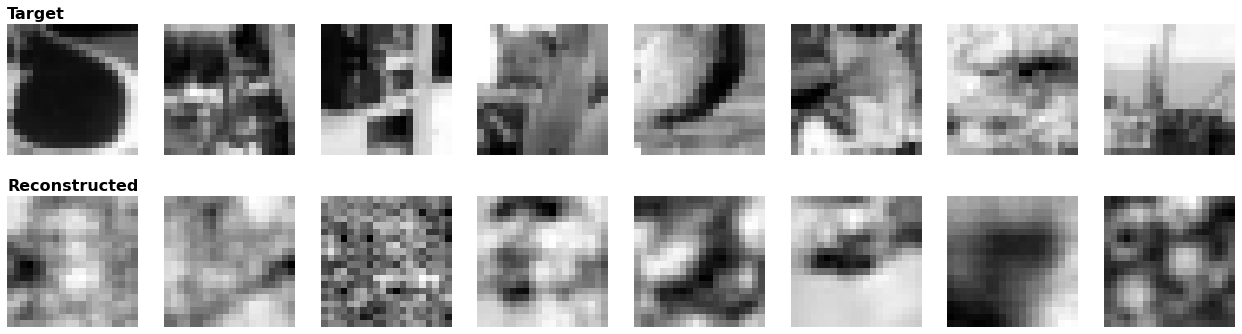

[1/150]
  [0/44992 (0%)] G-loss: 0.570 (stim: 0.236, adv: 0.334)   D-loss: 0.154 (real: 0.048, fake: 0.106)
  [6400/44992 (14%)] G-loss: 0.665 (stim: 0.227, adv: 0.438)   D-loss: 0.106 (real: 0.033, fake: 0.073)
  [12800/44992 (28%)] G-loss: 0.840 (stim: 0.227, adv: 0.613)   D-loss: 0.094 (real: 0.063, fake: 0.031)
  [19200/44992 (43%)] G-loss: 0.798 (stim: 0.231, adv: 0.568)   D-loss: 0.174 (real: 0.145, fake: 0.030)
  [25600/44992 (57%)] G-loss: 0.674 (stim: 0.238, adv: 0.436)   D-loss: 0.158 (real: 0.061, fake: 0.097)
  [32000/44992 (71%)] G-loss: 0.711 (stim: 0.229, adv: 0.483)   D-loss: 0.094 (real: 0.034, fake: 0.060)
  [38400/44992 (85%)] G-loss: 0.967 (stim: 0.243, adv: 0.723)   D-loss: 0.031 (real: 0.020, fake: 0.011)
  [44800/44992 (100%)] G-loss: 1.054 (stim: 0.250, adv: 0.803)   D-loss: 0.164 (real: 0.159, fake: 0.006)
val_losses['total']=0.4616, cat_v1: 0.4616


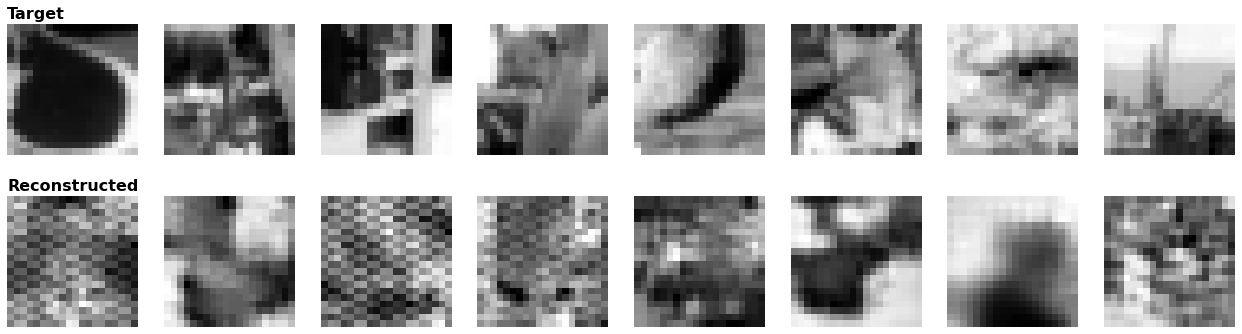

[2/150]
  [0/44992 (0%)] G-loss: 1.048 (stim: 0.244, adv: 0.803)   D-loss: 0.108 (real: 0.103, fake: 0.005)
  [6400/44992 (14%)] G-loss: 0.622 (stim: 0.228, adv: 0.394)   D-loss: 0.062 (real: 0.003, fake: 0.059)
  [12800/44992 (28%)] G-loss: 0.799 (stim: 0.240, adv: 0.558)   D-loss: 0.054 (real: 0.013, fake: 0.041)
  [19200/44992 (43%)] G-loss: 0.313 (stim: 0.221, adv: 0.092)   D-loss: 0.262 (real: 0.000, fake: 0.261)
  [25600/44992 (57%)] G-loss: 0.715 (stim: 0.230, adv: 0.485)   D-loss: 0.155 (real: 0.097, fake: 0.059)
  [32000/44992 (71%)] G-loss: 0.911 (stim: 0.236, adv: 0.675)   D-loss: 0.121 (real: 0.087, fake: 0.033)
  [38400/44992 (85%)] G-loss: 0.545 (stim: 0.233, adv: 0.312)   D-loss: 0.100 (real: 0.004, fake: 0.096)
  [44800/44992 (100%)] G-loss: 0.849 (stim: 0.228, adv: 0.622)   D-loss: 0.124 (real: 0.106, fake: 0.017)
val_losses['total']=0.4410, cat_v1: 0.4410


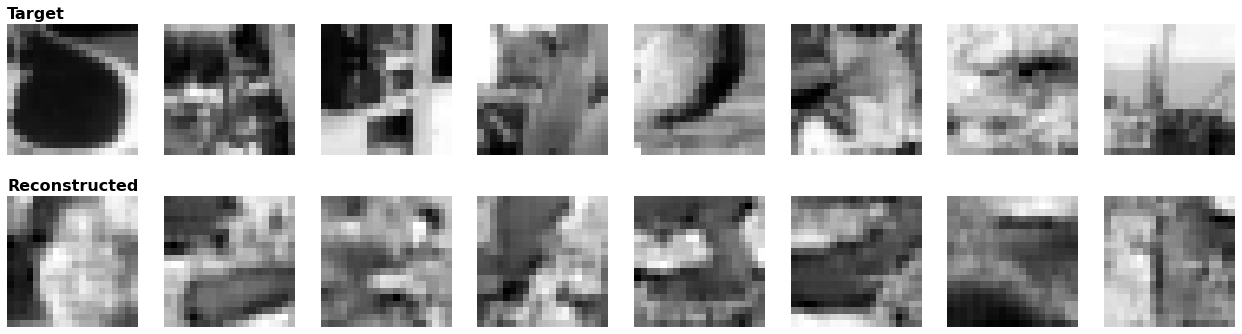

[3/150]
  [0/44992 (0%)] G-loss: 0.802 (stim: 0.235, adv: 0.567)   D-loss: 0.089 (real: 0.050, fake: 0.039)
  [6400/44992 (14%)] G-loss: 0.793 (stim: 0.229, adv: 0.564)   D-loss: 0.056 (real: 0.009, fake: 0.047)
  [12800/44992 (28%)] G-loss: 0.485 (stim: 0.221, adv: 0.263)   D-loss: 0.166 (real: 0.011, fake: 0.155)
  [19200/44992 (43%)] G-loss: 0.943 (stim: 0.231, adv: 0.712)   D-loss: 0.040 (real: 0.028, fake: 0.013)
  [25600/44992 (57%)] G-loss: 0.900 (stim: 0.230, adv: 0.670)   D-loss: 0.054 (real: 0.028, fake: 0.026)
  [32000/44992 (71%)] G-loss: 0.793 (stim: 0.234, adv: 0.559)   D-loss: 0.040 (real: 0.010, fake: 0.030)
  [38400/44992 (85%)] G-loss: 0.853 (stim: 0.223, adv: 0.630)   D-loss: 0.146 (real: 0.133, fake: 0.012)
  [44800/44992 (100%)] G-loss: 0.425 (stim: 0.237, adv: 0.188)   D-loss: 0.153 (real: 0.011, fake: 0.142)
val_losses['total']=0.4524, cat_v1: 0.4524


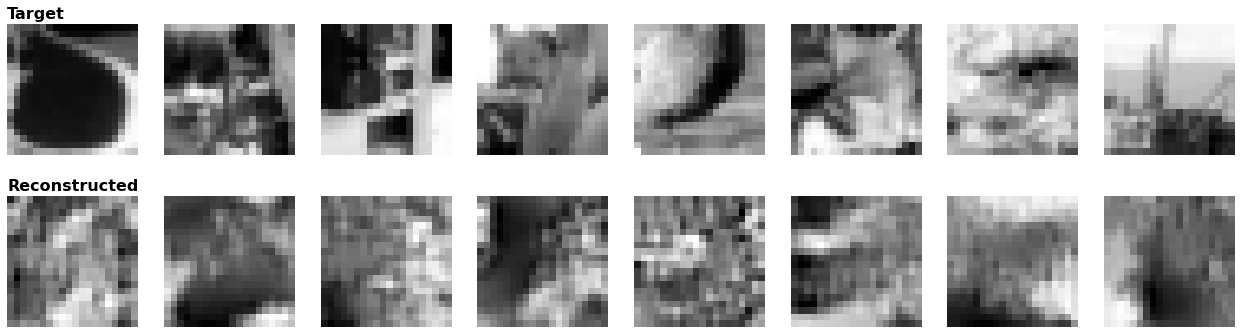

[4/150]
  [0/44992 (0%)] G-loss: 0.967 (stim: 0.229, adv: 0.738)   D-loss: 0.084 (real: 0.059, fake: 0.025)
  [6400/44992 (14%)] G-loss: 0.274 (stim: 0.230, adv: 0.044)   D-loss: 0.301 (real: 0.011, fake: 0.291)
  [12800/44992 (28%)] G-loss: 0.872 (stim: 0.224, adv: 0.647)   D-loss: 0.051 (real: 0.007, fake: 0.045)
  [19200/44992 (43%)] G-loss: 1.017 (stim: 0.215, adv: 0.802)   D-loss: 0.093 (real: 0.069, fake: 0.024)
  [25600/44992 (57%)] G-loss: 0.997 (stim: 0.236, adv: 0.762)   D-loss: 0.032 (real: 0.019, fake: 0.013)
  [32000/44992 (71%)] G-loss: 0.370 (stim: 0.252, adv: 0.118)   D-loss: 0.200 (real: 0.000, fake: 0.199)
  [38400/44992 (85%)] G-loss: 0.976 (stim: 0.227, adv: 0.749)   D-loss: 0.089 (real: 0.076, fake: 0.014)
  [44800/44992 (100%)] G-loss: 1.046 (stim: 0.214, adv: 0.831)   D-loss: 0.042 (real: 0.037, fake: 0.006)
val_losses['total']=0.4176, cat_v1: 0.4176


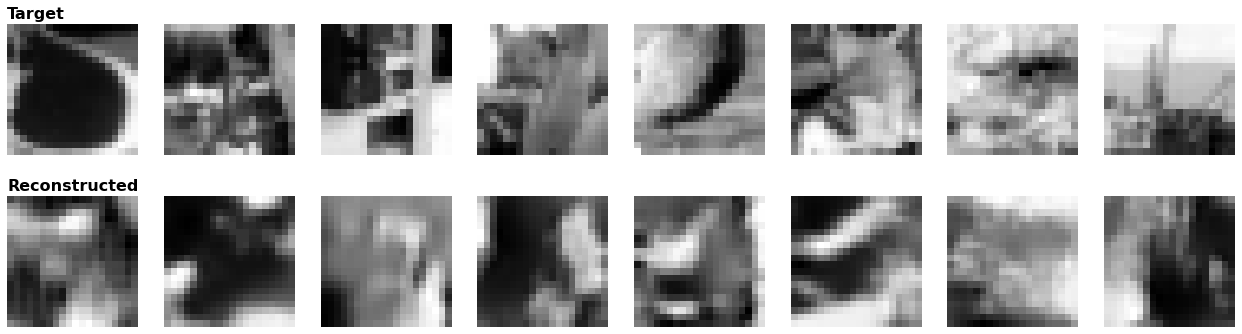

[5/150]
  [0/44992 (0%)] G-loss: 0.744 (stim: 0.215, adv: 0.529)   D-loss: 0.044 (real: 0.001, fake: 0.043)
  [6400/44992 (14%)] G-loss: 0.904 (stim: 0.236, adv: 0.668)   D-loss: 0.033 (real: 0.001, fake: 0.032)
  [12800/44992 (28%)] G-loss: 0.522 (stim: 0.224, adv: 0.298)   D-loss: 0.122 (real: 0.000, fake: 0.122)
  [19200/44992 (43%)] G-loss: 0.853 (stim: 0.228, adv: 0.625)   D-loss: 0.106 (real: 0.096, fake: 0.011)
  [25600/44992 (57%)] G-loss: 0.556 (stim: 0.236, adv: 0.320)   D-loss: 0.113 (real: 0.008, fake: 0.105)
  [32000/44992 (71%)] G-loss: 0.869 (stim: 0.213, adv: 0.656)   D-loss: 0.153 (real: 0.139, fake: 0.014)
  [38400/44992 (85%)] G-loss: 0.903 (stim: 0.241, adv: 0.662)   D-loss: 0.193 (real: 0.177, fake: 0.016)
  [44800/44992 (100%)] G-loss: 0.858 (stim: 0.203, adv: 0.655)   D-loss: 0.165 (real: 0.119, fake: 0.046)
val_losses['total']=0.4175, cat_v1: 0.4175


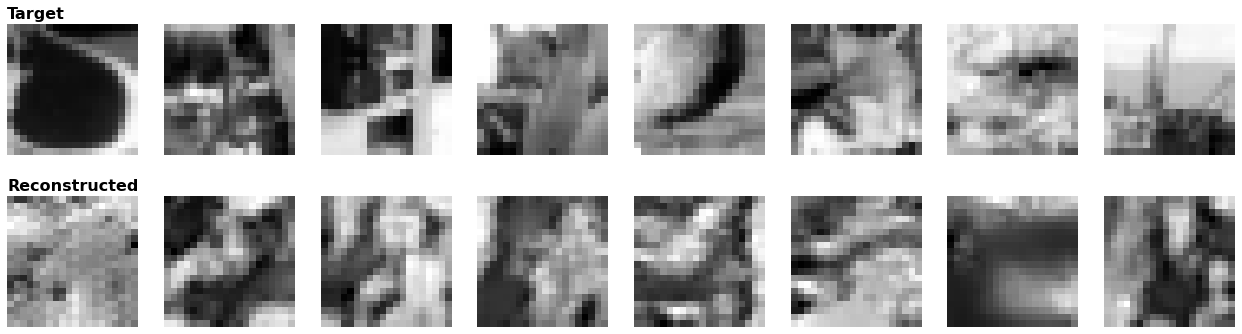

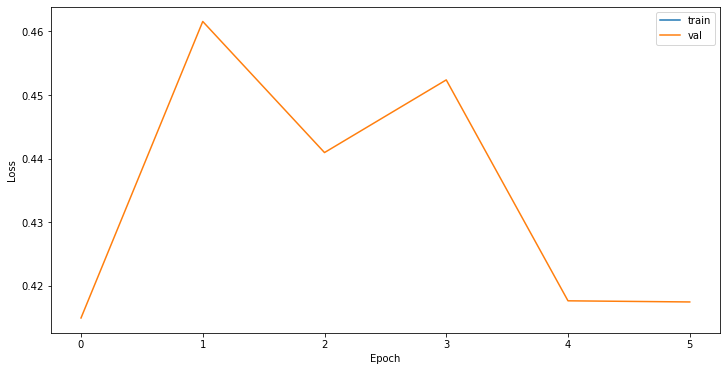

[6/150]
  [0/44992 (0%)] G-loss: 0.932 (stim: 0.228, adv: 0.704)   D-loss: 0.088 (real: 0.075, fake: 0.014)
  [6400/44992 (14%)] G-loss: 0.833 (stim: 0.216, adv: 0.618)   D-loss: 0.092 (real: 0.018, fake: 0.074)
  [12800/44992 (28%)] G-loss: 0.586 (stim: 0.229, adv: 0.357)   D-loss: 0.043 (real: 0.006, fake: 0.038)
  [19200/44992 (43%)] G-loss: 0.943 (stim: 0.225, adv: 0.718)   D-loss: 0.012 (real: 0.003, fake: 0.009)
  [25600/44992 (57%)] G-loss: 0.938 (stim: 0.224, adv: 0.714)   D-loss: 0.131 (real: 0.117, fake: 0.014)
  [32000/44992 (71%)] G-loss: 0.670 (stim: 0.232, adv: 0.437)   D-loss: 0.093 (real: 0.003, fake: 0.090)
  [38400/44992 (85%)] G-loss: 0.980 (stim: 0.230, adv: 0.750)   D-loss: 0.032 (real: 0.013, fake: 0.019)
  [44800/44992 (100%)] G-loss: 0.862 (stim: 0.252, adv: 0.610)   D-loss: 0.158 (real: 0.127, fake: 0.031)
val_losses['total']=0.4667, cat_v1: 0.4667


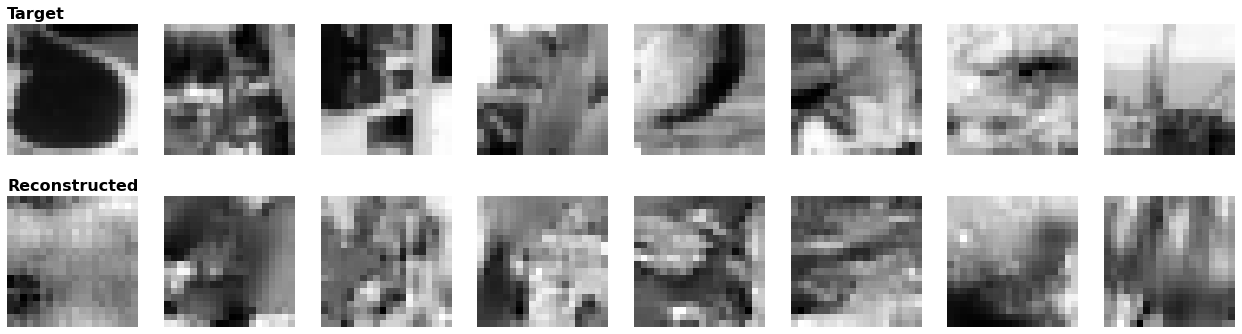

[7/150]
  [0/44992 (0%)] G-loss: 0.829 (stim: 0.227, adv: 0.601)   D-loss: 0.078 (real: 0.036, fake: 0.042)
  [6400/44992 (14%)] G-loss: 1.043 (stim: 0.227, adv: 0.815)   D-loss: 0.081 (real: 0.073, fake: 0.008)
  [12800/44992 (28%)] G-loss: 0.942 (stim: 0.238, adv: 0.705)   D-loss: 0.029 (real: 0.007, fake: 0.022)
  [19200/44992 (43%)] G-loss: 0.956 (stim: 0.211, adv: 0.745)   D-loss: 0.076 (real: 0.057, fake: 0.019)
  [25600/44992 (57%)] G-loss: 0.640 (stim: 0.211, adv: 0.429)   D-loss: 0.166 (real: 0.099, fake: 0.067)
  [32000/44992 (71%)] G-loss: 0.905 (stim: 0.218, adv: 0.687)   D-loss: 0.071 (real: 0.020, fake: 0.051)
  [38400/44992 (85%)] G-loss: 0.965 (stim: 0.219, adv: 0.746)   D-loss: 0.035 (real: 0.006, fake: 0.029)
  [44800/44992 (100%)] G-loss: 0.655 (stim: 0.225, adv: 0.430)   D-loss: 0.034 (real: 0.000, fake: 0.034)
val_losses['total']=0.4299, cat_v1: 0.4299


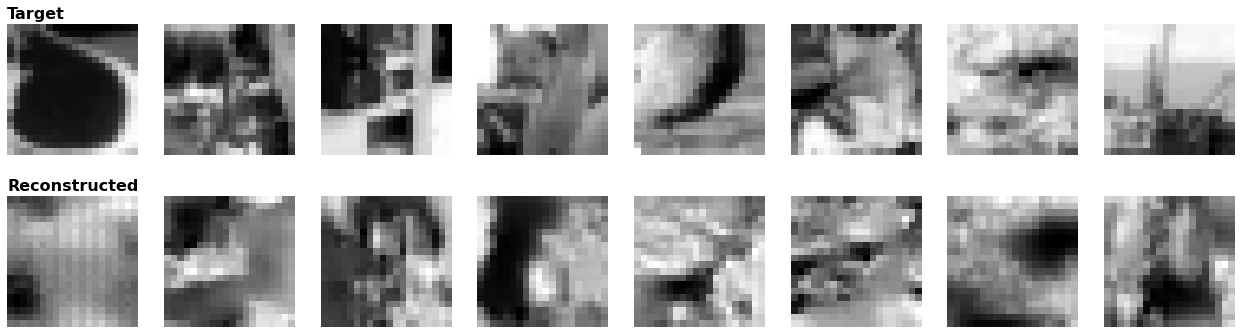

[8/150]
  [0/44992 (0%)] G-loss: 0.653 (stim: 0.221, adv: 0.432)   D-loss: 0.228 (real: 0.173, fake: 0.056)
  [6400/44992 (14%)] G-loss: 0.896 (stim: 0.217, adv: 0.679)   D-loss: 0.017 (real: 0.001, fake: 0.016)
  [12800/44992 (28%)] G-loss: 0.692 (stim: 0.230, adv: 0.462)   D-loss: 0.080 (real: 0.002, fake: 0.078)
  [19200/44992 (43%)] G-loss: 0.998 (stim: 0.223, adv: 0.775)   D-loss: 0.153 (real: 0.148, fake: 0.005)
  [25600/44992 (57%)] G-loss: 0.564 (stim: 0.214, adv: 0.350)   D-loss: 0.075 (real: 0.002, fake: 0.073)
  [32000/44992 (71%)] G-loss: 1.029 (stim: 0.209, adv: 0.820)   D-loss: 0.067 (real: 0.062, fake: 0.005)
  [38400/44992 (85%)] G-loss: 0.725 (stim: 0.235, adv: 0.491)   D-loss: 0.052 (real: 0.003, fake: 0.049)
  [44800/44992 (100%)] G-loss: 0.767 (stim: 0.227, adv: 0.541)   D-loss: 0.073 (real: 0.030, fake: 0.043)
val_losses['total']=0.4260, cat_v1: 0.4260


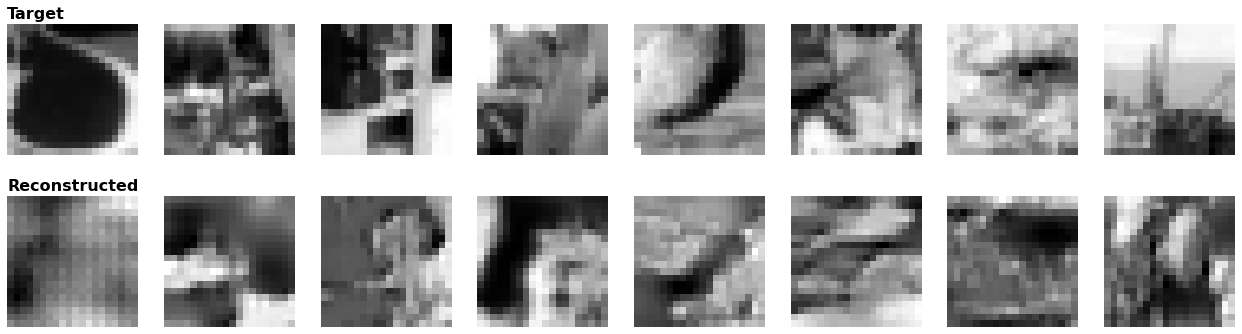

[9/150]
  [0/44992 (0%)] G-loss: 0.775 (stim: 0.215, adv: 0.560)   D-loss: 0.065 (real: 0.014, fake: 0.051)
  [6400/44992 (14%)] G-loss: 0.927 (stim: 0.217, adv: 0.710)   D-loss: 0.037 (real: 0.002, fake: 0.035)
  [12800/44992 (28%)] G-loss: 0.641 (stim: 0.214, adv: 0.427)   D-loss: 0.148 (real: 0.061, fake: 0.087)
  [19200/44992 (43%)] G-loss: 1.122 (stim: 0.223, adv: 0.899)   D-loss: 0.074 (real: 0.072, fake: 0.002)
  [25600/44992 (57%)] G-loss: 0.568 (stim: 0.225, adv: 0.343)   D-loss: 0.172 (real: 0.023, fake: 0.149)
  [32000/44992 (71%)] G-loss: 0.904 (stim: 0.233, adv: 0.671)   D-loss: 0.025 (real: 0.000, fake: 0.025)
  [38400/44992 (85%)] G-loss: 1.147 (stim: 0.225, adv: 0.922)   D-loss: 0.005 (real: 0.004, fake: 0.001)
  [44800/44992 (100%)] G-loss: 0.825 (stim: 0.202, adv: 0.622)   D-loss: 0.048 (real: 0.004, fake: 0.044)
val_losses['total']=0.4114, cat_v1: 0.4114


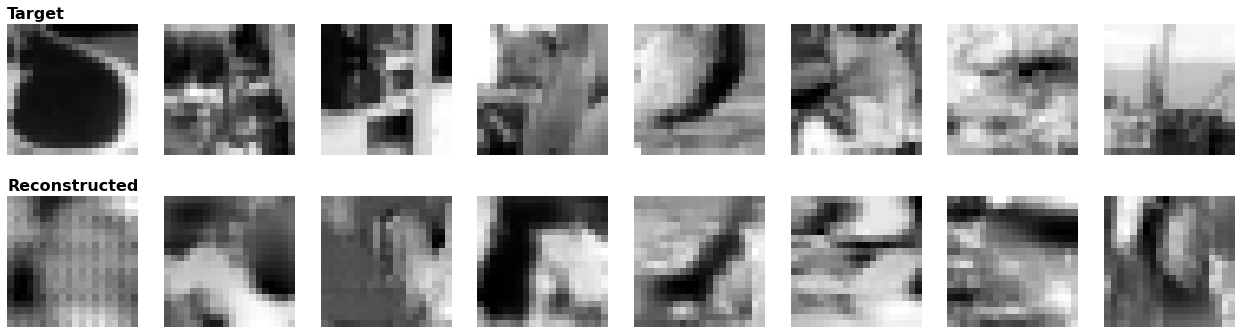

[10/150]
  [0/44992 (0%)] G-loss: 1.117 (stim: 0.209, adv: 0.908)   D-loss: 0.027 (real: 0.027, fake: 0.001)
  [6400/44992 (14%)] G-loss: 0.903 (stim: 0.224, adv: 0.678)   D-loss: 0.006 (real: 0.000, fake: 0.005)
  [12800/44992 (28%)] G-loss: 1.055 (stim: 0.233, adv: 0.822)   D-loss: 0.026 (real: 0.007, fake: 0.019)
  [19200/44992 (43%)] G-loss: 1.082 (stim: 0.220, adv: 0.862)   D-loss: 0.067 (real: 0.063, fake: 0.004)
  [25600/44992 (57%)] G-loss: 1.156 (stim: 0.228, adv: 0.928)   D-loss: 0.012 (real: 0.009, fake: 0.003)
  [32000/44992 (71%)] G-loss: 1.074 (stim: 0.236, adv: 0.838)   D-loss: 0.045 (real: 0.032, fake: 0.013)


KeyboardInterrupt: 

In [20]:
### train
s, e = len(history["train_loss"]), config["decoder"]["n_epochs"]
for epoch in range(s, e):
    print(f"[{epoch}/{e}]")

    ### train and val
    train_dataloader, val_dataloader, _ = get_dataloaders(
        config=config,
        dataloaders=dataloaders,
        only_cat_v1_eval=config["only_cat_v1_eval"],
    )
    history = train(
        model=decoder,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        config=config,
        history=history,
        wdb_run=wdb_run,
        wdb_commit=False,
    )
    val_losses = val(
        model=decoder,
        dataloader=val_dataloader,
        loss_fn=loss_fn,
    )

    ### save best model
    if val_losses["total"] < best["val_loss"]:
        best["val_loss"] = val_losses["total"]
        best["epoch"] = epoch
        best["model"] = deepcopy(decoder.state_dict())

    ### log
    history["val_loss"].append(val_losses["total"])
    print(f"Validation loss={val_losses['total']:.4f}")
    if config["wandb"]: wdb_run.log({"val_loss": val_losses["total"]}, commit=False)

    ### plot reconstructions
    stim_pred = decoder(resp[:8].to(config["device"]), neuron_coords=neuron_coords[:8].to(config["device"]), data_key="cat_v1").detach()
    fig = plot_comparison(target=crop(stim[:8], config["crop_win"]).cpu(), pred=crop(stim_pred[:8], config["crop_win"]).cpu(), save_to=make_sample_path(epoch, ""))
    if config["wandb"]: wdb_run.log({"val_stim_reconstruction": fig})
    
    ### plot losses + save ckpt
    if epoch % 5 == 0 and epoch > 0:
        plot_losses(history=history, epoch=epoch, save_to=os.path.join(config["dir"], f"losses_{epoch}.png") if config["decoder"]["save_run"] else None)

        ### ckpt
        if config["decoder"]["save_run"]:
            torch.save({
                "decoder": decoder.state_dict(),
                "history": history,
                "config": config,
                "best": best,
            }, os.path.join(config["dir"], "ckpt", f"decoder_{epoch}.pt"), pickle_module=dill)

In [21]:
### final evaluation + logging + saving
print(f"Best val loss: {best['val_loss']:.4f} at epoch {best['epoch']}")

### save final ckpt
if config["decoder"]["save_run"]:
    torch.save({
        "decoder": decoder.state_dict(),
        "history": history,
        "config": config,
        "best": best,
    }, os.path.join(config["dir"], f"decoder.pt"), pickle_module=dill)

### eval on test set w/ current params
print("Evaluating on test set with current model...")
_, _, test_dataloader = get_dataloaders(
    config=config,
    dataloaders=dataloaders,
    only_cat_v1_eval=config["only_cat_v1_eval"],
)
test_loss_curr = val(
    model=decoder,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
)
print(f"  Test loss (current model): {test_loss_curr['total']:.4f}")

### load best model
decoder.core.load_state_dict({".".join(k.split(".")[1:]):v for k,v in best["model"].items() if "G" in k or "D" in k})
decoder.readins.load_state_dict({".".join(k.split(".")[1:]):v for k,v in best["model"].items() if "readin" in k})

### eval on test set w/ best params
print("Evaluating on test set with best model...")
_, _, test_dataloader = get_dataloaders(
    config=config,
    dataloaders=dataloaders,
    only_cat_v1_eval=config["only_cat_v1_eval"],
)
test_loss_final = val(
    model=decoder,
    dataloader=test_dataloader,
    loss_fn=loss_fn,
)
print(f"  Test loss (best model): {test_loss_final['total']:.4f}")

### plot reconstructions of the final model
stim_pred_best = decoder(
    resp.to(config["device"]),
    data_key=sample_data_key,
    neuron_coords=neuron_coords,
).detach().cpu()
fig = plot_comparison(
    target=crop(stim[:8], config["crop_win"]).cpu(),
    pred=crop(stim_pred_best[:8], config["crop_win"]).cpu(),
    save_to=os.path.join(config["dir"], "stim_comparison_best.png") if config["decoder"]["save_run"] else None,
)

### log
if config["wandb"]:
    wandb.run.summary["best_val_loss"] = best["val_loss"]
    wandb.run.summary["best_epoch"] = best["epoch"]
    wandb.run.summary["curr_test_loss"] = test_loss_curr["total"]
    wandb.run.summary["final_test_loss"] = test_loss_final["total"]
    wandb.run.summary["best_reconstruction"] = fig

### save/delete wandb run
if config["wandb"]:
    print("Finishing wandb run...")
    wdb_run.finish()

### plot losses
plot_losses(
    history=history,
    save_to=None if not config["decoder"]["save_run"] else os.path.join(config["dir"], f"losses.png"),
)

Best val loss: 0.4114 at epoch 9
Evaluating on test set with current model...
  Test loss (current model): 0.4106
Evaluating on test set with best model...
  Test loss (best model): 0.3812


IndexError: too many indices for tensor of dimension 3